<a href="https://colab.research.google.com/github/promckkon/1DCNN/blob/main/MK-catboost%20with%2010%20NOISE%20in%20CWRU%20Dataset%20251118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [72]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_10_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_OR014_6_1_202.mat


/tmp/ipython-input-2478851265.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['Noise_10_OR014_6_1_202']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_OR007_6_1_136.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_B014_1_190.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136' 'Noise_10_B014_1_190']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_B021_1_227.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136' 'Noise_10_B014_1_190'
 'Noise_10_B021_1_227']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_Time_Normal_1_098.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136' 'Noise_10_B014_1_190'
 'Noise_10_B021_1_227' 'Noise_10_Time_Normal_1_098']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_IR007_1_110.mat
['Noise_10_OR014_6_1_202' 'Noise_10_OR007_6_1_136' 'Noise_10_B014_1_190'
 'Noise_10_B021_1_227' 'Noise_10_Time_Normal_1_098' 'Noise_10_IR007_1_110']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_10/Noise_10_OR021

# Multi-Kernel Deep 1D-CNN

In [73]:
pip install tensorflow

In [74]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [75]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 9


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 2232, 64)  │     12,864 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 2332, 64)  │      6,464 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 2382, 64)  │      3,264 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2232, 64)  │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 2332, 64)  │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2382, 64)  │          0 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 111, 64)   │          0 │ dropout_6[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 233, 64)   │          0 │ dropout_7[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 476, 64)   │          0 │ dropout_8[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 7104)      │          0 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 14912)     │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 30464)     │          0 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 52480)     │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │  5,248,100 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 9)         │        909 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,271,601 (20.11 MB)

 Trainable params: 5,271,601 (20.11 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 547ms/step - accuracy: 0.1294 - loss: 4.2603 - val_accuracy: 0.2018 - val_loss: 1.9035
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3124 - loss: 1.6590 - val_accuracy: 0.3858 - val_loss: 1.3505
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5159 - loss: 1.1378 - val_accuracy: 0.7463 - val_loss: 1.0201
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7502 - loss: 0.7194 - val_accuracy: 0.9036 - val_loss: 0.7254
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9087 - loss: 0.4851 - val_accuracy: 0.9303 - val_loss: 0.5244
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9659 - loss: 0.2323 - val_accuracy: 0.9303 - val_loss: 0.4139
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9706 - loss: 0.1417 - val_accuracy: 0.9377 - val_loss: 0.2943
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9563 - loss: 0.1154 - val_accuracy: 0.9184 -

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


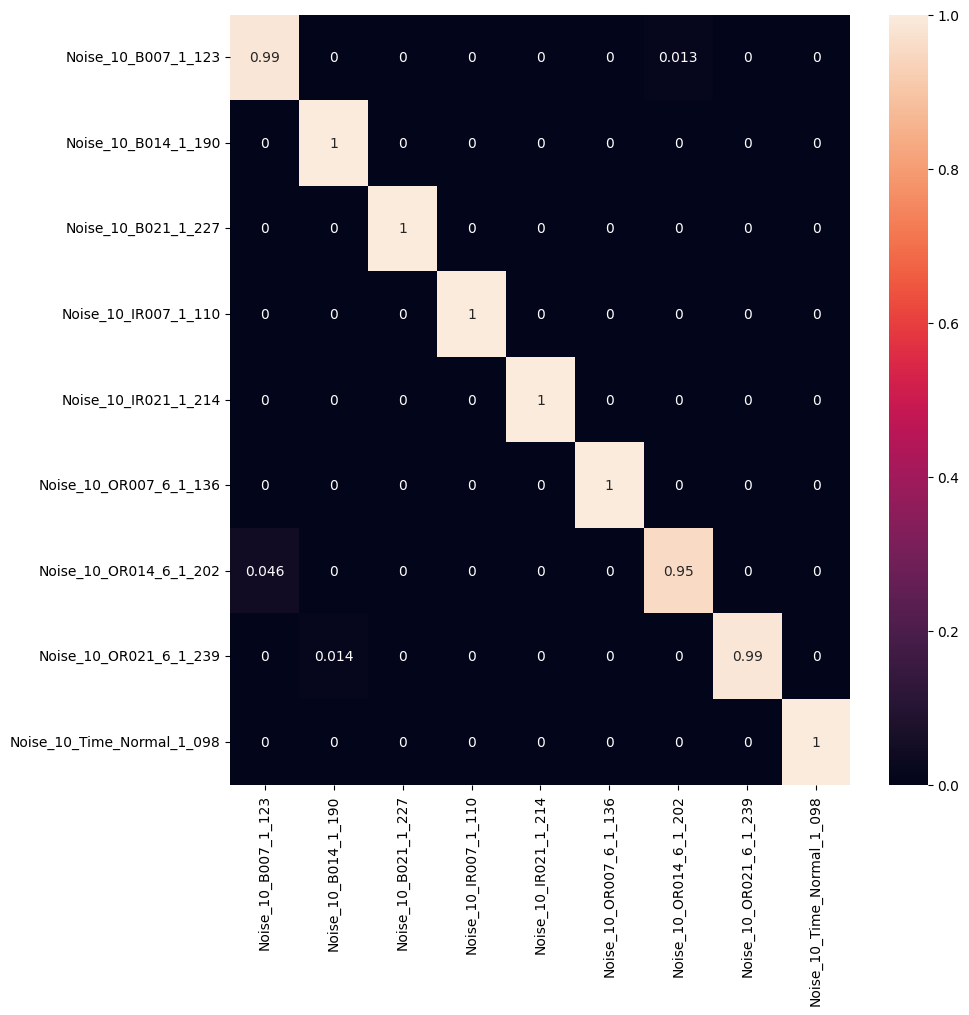

In [78]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [79]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.002s...
[t-SNE] Computed neighbors for 1570 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 1.086894
[t-SNE] Computed conditional probabilities in 0.047s


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Iteration 50: error = 56.5500793, gradient norm = 0.0486490 (50 iterations in 0.594s)
[t-SNE] Iteration 100: error = 51.2803917, gradient norm = 0.0183268 (50 iterations in 0.467s)
[t-SNE] Iteration 150: error = 50.0730858, gradient norm = 0.0110899 (50 iterations in 0.470s)
[t-SNE] Iteration 200: error = 49.4907074, gradient norm = 0.0074492 (50 iterations in 0.456s)
[t-SNE] Iteration 250: error = 49.1256981, gradient norm = 0.0071960 (50 iterations in 0.458s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.125698
[t-SNE] Iteration 300: error = 0.8829972, gradient norm = 0.0155195 (50 iterations in 0.462s)
[t-SNE] Iteration 350: error = 0.6338075, gradient norm = 0.0141749 (50 iterations in 0.497s)
[t-SNE] Iteration 400: error = 0.5312864, gradient norm = 0.0122020 (50 iterations in 0.479s)
[t-SNE] Iteration 450: error = 0.4796912, gradient norm = 0.0107721 (50 iterations in 0.483s)
[t-SNE] Iteration 500: error = 0.4492872, gradient norm = 0.0094292 (50 

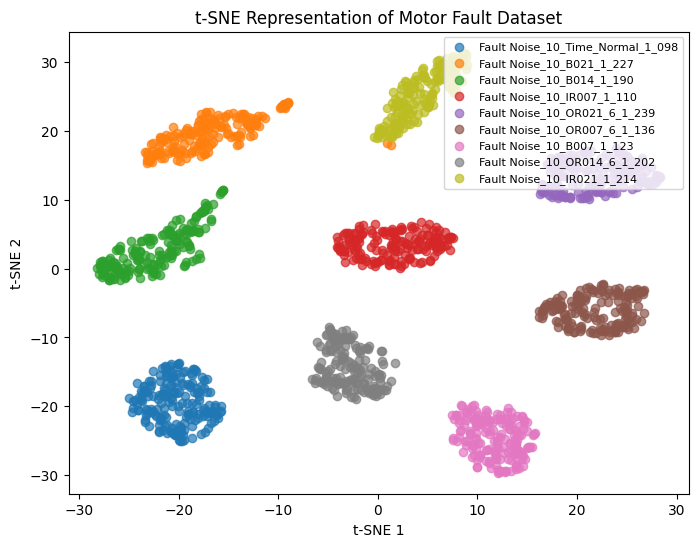

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_10_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_10_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(
    loc='upper right',   # 位置一樣
    fontsize=8,          # 標籤字體變小（預設大概 10）
    title_fontsize=9     # 如果有 legend title，也一起縮小
)
plt.show()

Statistical Features

In [81]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_10_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2431, STRIDE: 1944
Extracted 2244 rows (target: 1800)
                       fault  window      mean       std       rms       max  \
0     Noise_10_OR014_6_1_202       1  0.015249  0.146771  0.147561  0.594737   
1     Noise_10_OR014_6_1_202       2  0.013508  0.146190  0.146813  0.594737   
2     Noise_10_OR014_6_1_202       3  0.014151  0.150835  0.151498  0.498249   
3     Noise_10_OR014_6_1_202       4  0.012434  0.152739  0.153244  0.559526   
4     Noise_10_OR014_6_1_202       5  0.009703  0.141148  0.141482  0.516066   
...                      ...     ...       ...       ...       ...       ...   
2239     Noise_10_B007_1_123     246  0.016597  0.149658  0.150575  0.593600   
2240     Noise_10_B007_1_123     247  0.015316  0.173308  0.173983  0.622776   
2241     Noise_10_B007_1_123     248  0.015049  0.151986  0.152729  0.479625   
2242     Noise_10_B007_1_123     249  0.017314  0.153895  0.154866  0.650435   
2243     Noise_10_B007_1_123     250  0.01

In [82]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_10_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_10_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_10_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
Noise_10_OR021_6_1_239        251
Noise_10_B007_1_123           250
Noise_10_OR007_6_1_136        250
Noise_10_B021_1_227           250
Noise_10_IR007_1_110          249
Noise_10_IR021_1_214          249
Noise_10_B014_1_190           249
Noise_10_OR014_6_1_202        248
Noise_10_Time_Normal_1_098    248
Name: count, dtype: int64
Current rows after equal resampling: 1566
New class distribution:
fault
Noise_10_Time_Normal_1_098    175
Noise_10_B014_1_190           175
Noise_10_OR014_6_1_202        175
Noise_10_IR007_1_110          175
Noise_10_IR021_1_214          174
Noise_10_B021_1_227           174
Noise_10_OR007_6_1_136        174
Noise_10_B007_1_123           174
Noise_10_OR021_6_1_239        174
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_10_balanced_dataset_equal_resampling_exact_1570.csv'


In [83]:
balanced_df.shape

(1570, 11)

In [84]:
balanced_df=balanced_df.sort_values(by='fault')

In [85]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
504,Noise_10_B007_1_123,165,0.015987,0.136025,0.136961,0.414769,-0.449486,-0.048481,-0.110364,1.249143,3.028363
1039,Noise_10_B007_1_123,234,0.019883,0.167880,0.169053,0.592308,-0.598465,0.018099,0.118380,1.263034,3.503674
1026,Noise_10_B007_1_123,191,0.019403,0.141624,0.142947,0.477345,-0.420091,0.032283,-0.292770,1.235102,3.339311
1023,Noise_10_B007_1_123,166,0.018389,0.135462,0.136704,0.405986,-0.432351,-0.098870,-0.273288,1.229656,2.969821
1021,Noise_10_B007_1_123,196,0.019244,0.157987,0.159154,0.618161,-0.608991,-0.034724,-0.018576,1.247988,3.884035
...,...,...,...,...,...,...,...,...,...,...,...
1073,Noise_10_Time_Normal_1_098,223,0.014381,0.064458,0.066043,0.199192,-0.202400,-0.161352,-0.207077,1.233562,3.016091
1069,Noise_10_Time_Normal_1_098,57,0.013170,0.068218,0.069478,0.220410,-0.195262,-0.072905,-0.169053,1.236968,3.172358
124,Noise_10_Time_Normal_1_098,129,0.013798,0.071961,0.073272,0.224994,-0.241218,-0.186308,-0.022872,1.252557,3.070666
1105,Noise_10_Time_Normal_1_098,116,0.017567,0.068281,0.070505,0.265444,-0.233762,-0.104933,-0.017849,1.233955,3.764899


     t-SNE 1    t-SNE 2                fault
0  32.255474  -7.569028  Noise_10_B007_1_123
1  39.820667  -1.244522  Noise_10_B007_1_123
2  29.230070  11.426721  Noise_10_B007_1_123
3  28.761621  22.177374  Noise_10_B007_1_123
4  28.058859  17.769859  Noise_10_B007_1_123


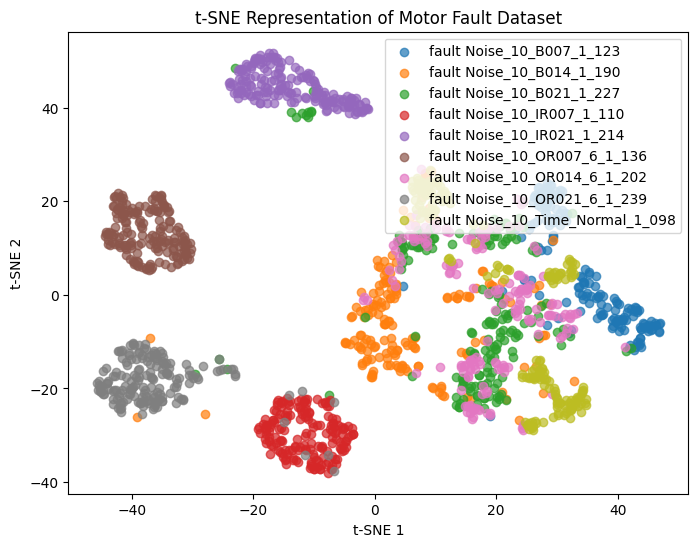

In [86]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [87]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,32.255474,-7.569028,Noise_10_B007_1_123
1,39.820667,-1.244522,Noise_10_B007_1_123
2,29.230070,11.426721,Noise_10_B007_1_123
3,28.761621,22.177374,Noise_10_B007_1_123
4,28.058859,17.769859,Noise_10_B007_1_123
...,...,...,...
1565,7.056748,24.427645,Noise_10_Time_Normal_1_098
1566,30.127686,-25.603350,Noise_10_Time_Normal_1_098
1567,25.546106,-28.083755,Noise_10_Time_Normal_1_098
1568,7.688811,22.301249,Noise_10_Time_Normal_1_098


In [88]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,32.255474,-7.569028
1,39.820667,-1.244522
2,29.230070,11.426721
3,28.761621,22.177374
4,28.058859,17.769859
...,...,...
1565,7.056748,24.427645
1566,30.127686,-25.603350
1567,25.546106,-28.083755
1568,7.688811,22.301249


In [89]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [90]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
784,12.116345,-29.354294,Noise_10_B007_1_123
605,9.264668,-23.543909,Noise_10_B007_1_123
1402,10.873393,-20.542118,Noise_10_B007_1_123
598,9.909427,-27.825035,Noise_10_B007_1_123
597,9.621503,-19.832954,Noise_10_B007_1_123
...,...,...,...
467,-19.493221,-23.445095,Noise_10_Time_Normal_1_098
458,-23.211250,-17.958735,Noise_10_Time_Normal_1_098
456,-20.161209,-18.039642,Noise_10_Time_Normal_1_098
1010,-17.144669,-21.374786,Noise_10_Time_Normal_1_098


Combined Features

In [91]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
784,-10.712178,45.596584,12.116345,-29.354294,Noise_10_B007_1_123
605,-12.710435,-24.035677,9.264668,-23.543909,Noise_10_B007_1_123
1402,6.254037,22.366199,10.873393,-20.542118,Noise_10_B007_1_123
598,-7.756712,-25.925076,9.909427,-27.825035,Noise_10_B007_1_123
597,-15.642222,-33.496437,9.621503,-19.832954,Noise_10_B007_1_123
...,...,...,...,...,...
467,26.309307,10.479639,-19.493221,-23.445095,Noise_10_Time_Normal_1_098
458,21.025234,-17.658152,-23.211250,-17.958735,Noise_10_Time_Normal_1_098
456,15.842886,-19.383120,-20.161209,-18.039642,Noise_10_Time_Normal_1_098
1010,-38.696655,15.974605,-17.144669,-21.374786,Noise_10_Time_Normal_1_098


In [92]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [93]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

y_shuffled = np.random.permutation(y)

In [94]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2    ,random_state=42,
    shuffle=True,
    stratify=y  )

In [95]:
!pip install catboost

Deployment:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1885090	test: 2.1885325	best: 2.1885325 (0)	total: 1.17ms	remaining: 57.1ms
49:	learn: 1.8363351	test: 1.8361636	best: 1.8361636 (49)	total: 44.5ms	remaining: 0us

bestTest = 1.836163631
bestIteration = 49

Train Accuracy: 0.9689
Test  Accuracy: 0.9618

Classification Report - Training Set:
                            precision    recall  f1-score   support

       Noise_10_B007_1_123       1.00      1.00      1.00       137
       Noise_10_B014_1_190       1.00      0.99      0.99       142
       Noise_10_B021_1_227       0.99      0.99      0.99       142
      Noise_10_IR007_1_110       1.00      1.00      1.00       139
      Noise_10_IR021_1_214       0.99      1.00      0.99       137
    Noise_10_OR007_6_1_136       1.00      1.00      1.00       136
    Noise_10_OR014_6_1_202       1.00      0.73      0.84       129
    Noise_10_OR021_6_1_239       1.00      1.00      1.00       145
Noise_10_Time_Normal_1_098       0.81      1.00      0.89       149

              

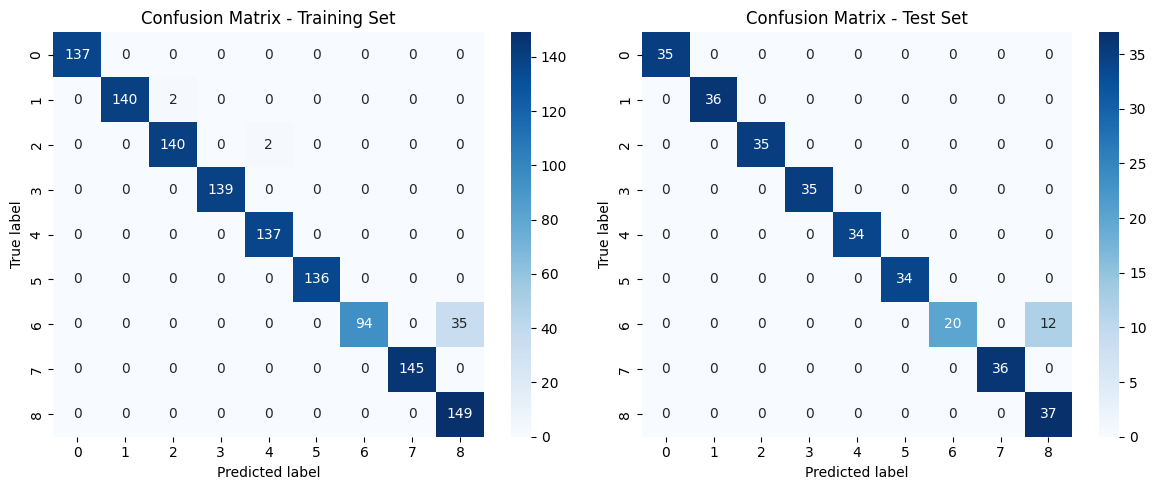

In [98]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

cat_model = CatBoostClassifier(
    iterations=50,
    depth=1,
    learning_rate=0.01,
    l2_leaf_reg=5,
    bagging_temperature=1.5,
    random_strength=1.5,
    random_seed=42,
    verbose=50
)

# === 訓練模型 ===
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # 用測試集當驗證集看學習曲線
    plot=True                   # 在 Colab 畫出學習曲線
)
# ========= 1. 對 Train / Test 都做預測 =========
y_train_pred = cat_model.predict(X_train)
y_test_pred  = cat_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}\n")

# ========= 2. 印出 Train Set 的分類報告 =========
print("Classification Report - Training Set:")
print(classification_report(y_train, y_train_pred))

# ========= 3. 印出 Test Set 的分類報告 =========
print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_test_pred))

# ========= 4. 混淆矩陣：Train / Test 各一個 =========
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test,  y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Training Set")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")

plt.tight_layout()
plt.show()